## Train word2vec

In [16]:
from gensim.models.word2vec import Word2Vec
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

import pickle
GLOBALS = pickle.load(open('../data/globals.p', 'rb'))
GLOBALS

{'absolute_filepaths': {'metadata': '/Volumes/ARCHIVES/Thesis/data/metadata.csv',
  'conversion_log': '/Volumes/ARCHIVES/Thesis/data/conversion_log.csv',
  'xml': '/Volumes/ARCHIVES/Thesis/data/xml/',
  'archive': '/Volumes/ARCHIVES/Thesis/data/archive/',
  'corpus': '/Volumes/ARCHIVES/Thesis/data/corpus/',
  'data': '/Volumes/ARCHIVES/Thesis/data/',
  'root': '/Volumes/ARCHIVES/Thesis/',
  'lda': '/Volumes/ARCHIVES/Thesis/src/sporc/lda/',
  'doc2vec': '/Volumes/ARCHIVES/Thesis/src/sporc/doc2vec/'},
 'start': 2009,
 'end': 2019}

In [4]:
corpus = pd.read_csv(GLOBALS['absolute_filepaths']['data'] + 'metadata_astroph.csv',
                       dtype={'filename': str,
                              'filename_parsed': str,
                              'identifier': str,
                              'updated': str,
                              'doi': str,
                              'in_range': bool}) 
corpus

,identifier,filename,spec,title,datestamp,created,updated,authors,categories,journal,doi,abstract,comments,filename_parsed,in_range,subcategories,is_single_domain,domain,primary
0,oai:arXiv.org:1710.06630,1710.06630,physics:astro-ph,A detailed study of Lithium in 107 CHEPS dwarf...,2018-03-21,2017-10-18,NaN,"Ya. V. Pavlenko, J. S. Jenkins, O. M. Ivanyuk,...",astro-ph.SR,"A&A 611, A27 (2018)",10.1051/0004-6361/201731547,We report results from lithium abundance det...,NaN,1710.06630,True,['astro-ph.SR'],True,astro-ph.SR,astro-ph.SR
1,oai:arXiv.org:1710.06659,1710.06659,physics:astro-ph,About the consistency of the energy scales of ...,2017-10-19,2017-10-18,NaN,Antonio Codino,astro-ph.HE,NaN,NaN,The energy spectrum of the cosmic radiation ...,NaN,1710.06659,True,['astro-ph.HE'],True,astro-ph.HE,astro-ph.HE
2,oai:arXiv.org:1710.06696,1710.06696,physics:astro-ph,A possible formation scenario for dwarf sphero...,2017-12-13,2017-10-18,NaN,"A. G. Alarcon Jara, M. Fellhauer, D. R. Matus ...",astro-ph.GA,NaN,10.1093/mnras/stx2712,Dwarf spheroidal galaxies are regarded as th...,NaN,1710.06696,True,['astro-ph.GA'],True,astro-ph.GA,astro-ph.GA
3,oai:arXiv.org:1710.06709,1710.06709,physics:astro-ph,A cautionary tale of interpreting O-C diagrams...,2017-10-19,2017-10-18,NaN,"M. Skarka, J. Liška, R. Dřevěný, E. Guggenberg...",astro-ph.SR,NaN,10.1093/mnras/stx2737,"We present a comprehensive study of Z CVn, a...",NaN,1710.06709,True,['astro-ph.SR'],True,astro-ph.SR,astro-ph.SR
4,oai:arXiv.org:1710.06713,1710.06713,physics:astro-ph,Recollimation shocks and radiative losses in e...,2018-02-07,2017-10-18,NaN,"G. Bodo, F. Tavecchio",astro-ph.HE,"A&A 609, A122 (2018)",10.1051/0004-6361/201732000,We present the results of state-of-the-art s...,NaN,1710.06713,True,['astro-ph.HE'],True,astro-ph.HE,astro-ph.HE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103721,oai:arXiv.org:1710.06547,1710.06547,physics:astro-ph,The Behavior of Selected Diffuse Interstellar ...,2017-12-13,2017-10-17,NaN,"Haoyu Fan, Daniel E. Welty, Donald G. York, Pa...",astro-ph.GA,NaN,10.3847/1538-4357/aa9480,We study the behavior of eight diffuse inter...,NaN,1710.06547,True,['astro-ph.GA'],True,astro-ph.GA,astro-ph.GA
103722,oai:arXiv.org:1710.06557,1710.06557,physics:astro-ph,Atomic Gas in Blue Ultra Diffuse Galaxies arou...,2018-03-14,2017-10-17,2018-01-09,"Kristine Spekkens, Ananthan Karunakaran",astro-ph.GA,NaN,10.3847/1538-4357/aa94be,We have found the atomic gas (HI) reservoirs...,NaN,1710.06557,True,['astro-ph.GA'],True,astro-ph.GA,astro-ph.GA
103723,oai:arXiv.org:1710.06599,1710.06599,physics:astro-ph,A history of violence: insights into post-accr...,2017-10-19,2017-10-18,NaN,"Brandon Mahan, Frederic Moynier, Pierre Beck, ...",astro-ph.EP,"Geochimica et Cosmochimica Acta 22, 19-35 (2018)",10.1016/j.gca.2017.09.027,Carbonaceous chondrites (CCs) may have been ...,NaN,1710.06599,True,['astro-ph.EP'],True,astro-ph.EP,astro-ph.EP
103724,oai:arXiv.org:1710.06600,1710.06600,physics:astro-ph,Quantifying the AGN-driven outflows in ULIRGs ...,2017-12-20,2017-10-18,NaN,"Marvin Rose, Clive Tadhunter, Cristina Ramos A...",astro-ph.GA,NaN,10.1093/mnras/stx2590,Although now routinely incorporated into hyd...,NaN,1710.06600,True,['astro-ph.GA'],True,astro-ph.GA,astro-ph.GA


In [12]:
class DocumentIterator(object):
    '''Accepted formats: 
        - 'tfidf' — returns string
        - 'word2vec' — returns string
        - 'lda' — returns tokens
        - 'doc2vec' — returns TaggedDocument
    '''
    def load_documents(self):
        for filename in self.filenames: 
            try:
                with open(filename, 'r') as txtfile:
                    if self.which_format == 'tfidf':
                        yield txtfile.read()
                    elif self.which_format == 'lda' or self.which_format == 'word2vec':
                        yield txtfile.read().split(' ')
                    elif self.which_format == 'doc2vec':
                        tag = os.path.splitext(os.path.basename(filename))[0]
                        yield TaggedDocument(words=txtfile.read().split(' '), tags=[tag])
            except Exception as e:
                print('Error!' + str(e))
                
    def __init__(self, filenames, which_format):
        self.filenames = filenames
        self.which_format = which_format

    def __iter__(self):
        self.documents = self.load_documents() # Reset the iterator
        return self
    
    def __next__(self):
        doc = next(self.documents)
        return doc

In [6]:
root = '/Volumes/ARCHIVES/Thesis/data/abstract_corpus/astroph/'
filepaths = corpus['filename_parsed'].apply(lambda x: root + x + '.txt')
print('Documents:', len(filepaths))

Documents: 103726


Word2Vec expects a list of "sentences" (we treat the abstract as one sentence), with each sentence being a list of words.

In [ ]:
which = 'word2vec'
docs = DocumentIterator(filepaths, which)
w2v = Embedder(which)
model = w2v.embed(docs)

In [48]:
w2v = Embedder(which)
w2v.model = model
len(w2v.model.wv.vocab)

36606

In [21]:
model.most_similar('photon', topn=20)

/Users/briennakh/anaconda3/envs/thesis-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2020-12-20 00:51:43,622 : INFO : precomputing L2-norms of word weight vectors


[('photons', 0.5931137800216675),
 ('radiation', 0.4483383893966675),
 ('electron', 0.3794681131839752),
 ('proton', 0.3742159605026245),
 ('photopion', 0.3693360984325409),
 ('particle', 0.36558258533477783),
 ('mev', 0.363015741109848),
 ('gammas', 0.3601444959640503),
 ('photomeson', 0.3561919331550598),
 ('gev', 0.355324923992157),
 ('lepton', 0.35365891456604004),
 ('phonon', 0.35333576798439026),
 ('quanta', 0.3525170087814331),
 ('refractive', 0.34949636459350586),
 ('compton', 0.34858208894729614),
 ('thomson', 0.3485614061355591),
 ('klein', 0.34853437542915344),
 ('alp', 0.34649503231048584),
 ('pion', 0.3437957763671875),
 ('bremsstrahlung', 0.34087276458740234)]

In [22]:
model.most_similar([model.wv['atom'] - model.wv['electron']])

/Users/briennakh/anaconda3/envs/thesis-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('atom', 0.6079583168029785),
 ('protium', 0.3631671667098999),
 ('propynal', 0.36131033301353455),
 ('abstraction', 0.3554612398147583),
 ('chloride', 0.34734633564949036),
 ('sulphide', 0.33088409900665283),
 ('cyanide', 0.325298011302948),
 ('atoms', 0.3232601583003998),
 ('bonds', 0.3227415680885315),
 ('anions', 0.32189691066741943)]

In [25]:
def analogy(a, b, c):
    result = model.wv.most_similar(negative=[a], positive=[b, c])
    return result[0][0]

planets = ['earth', 'mars', 'pluto']
moons = [analogy('earth', 'luna', planet) for planet in planets]
moons

['wroclaw', 'rover', 'astrobear']

['lunar', 'europa', 'europa']

In [26]:
a = model.wv['newton']
b = model.wv['star']
c = model.wv['hole']
model.wv.most_similar([a + b + c])

[('hole', 0.6561089754104614),
 ('star', 0.6456553936004639),
 ('newton', 0.4846716523170471),
 ('holes', 0.4524524211883545),
 ('redbacks', 0.4164126217365265),
 ('widows', 0.4083765745162964),
 ('bh', 0.3991888463497162),
 ('widow', 0.38514846563339233),
 ('stars', 0.3765786588191986),
 ('smbh', 0.3747986853122711)]

Average word embeddings.

In [49]:
document_vectors = w2v.get_document_vectors()

In [52]:
clear

In [53]:
from sklearn.decomposition import PCA

In [55]:
reduced_data = PCA(n_components=3).fit_transform(w2v.document_vectors)

In [56]:
def scatter(x, y, target, size=20, alpha=0.3):
    '''data should have two columns at least, the first for x, second for y.'''
    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x=x,
        y=y,
        alpha=alpha,
        s=size,
        #hue=[subdomains.index(x[0]) for x in pure_corpus['subcategories'][:10000]],
        hue=target,
        legend='full',
        palette=sns.color_palette("hls", len(set(target)))
    )
    plt.show()
    
def scatter3d(x, y, z, target):
    fig = plt.figure(figsize=(10, 10))
    ax = Axes3D(fig)
    ax.scatter(xs=x,
               ys=y,
               zs=z,
               c=target,
               #c=clusterer.labels_,
               s=2)
    plt.axis('off')
    plt.show()

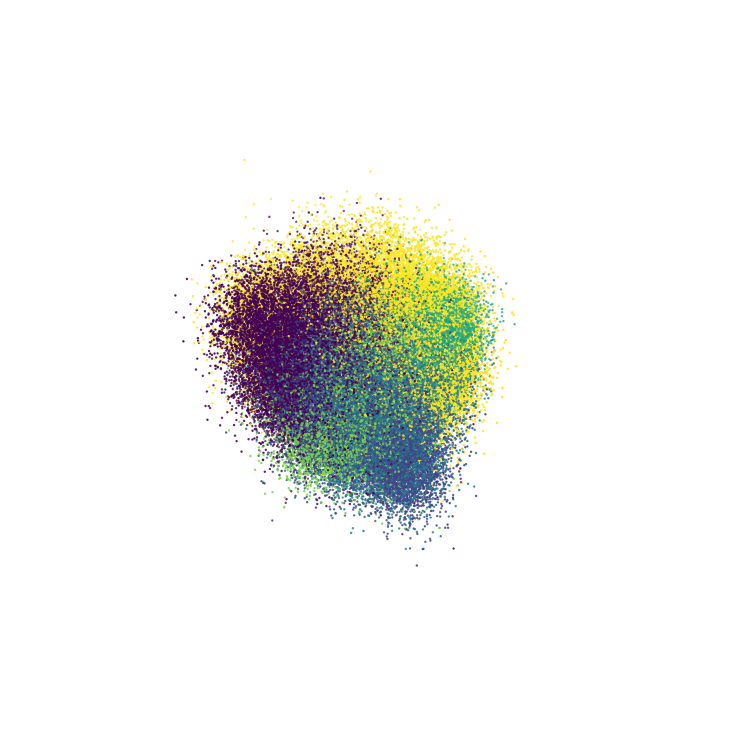

In [57]:
from mpl_toolkits.mplot3d import Axes3D
subdomains = ['astro-ph.GA', 'astro-ph.SR', 'astro-ph.HE', 'astro-ph.IM', 'astro-ph.EP', 'astro-ph.CO']
scatter3d(reduced_data[:,0], reduced_data[:,1], reduced_data[:,2], corpus['primary'].apply(lambda x: subdomains.index(x)))

2020-12-20 01:24:19,678 : INFO : NumExpr defaulting to 4 threads.


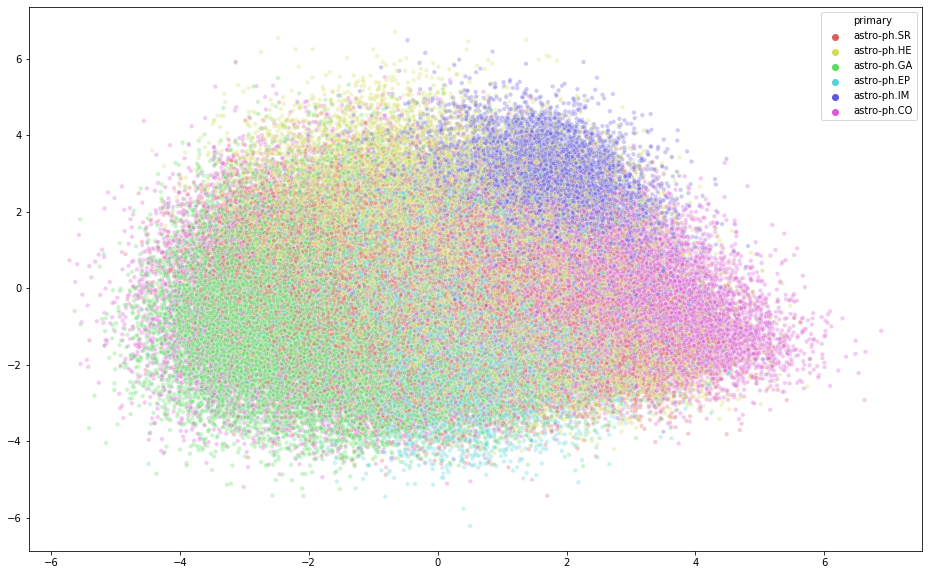

In [58]:
scatter(reduced_data[:,0], reduced_data[:,1], corpus['primary'])

In [75]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(avw, corpus['primary'])

In [ ]:
y_pred_svm = svm.predict(y_pred)
print('accuracy %s' % accuracy_score(y_pred_svm, y_test))
print(classification_report(y_test, y_pred_svm, target_names=domains))

In [70]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(w2v.document_vectors, corpus['primary'])

KeyboardInterrupt: 

In [66]:
y_pred = knn.predict(w2v.document_vectors[10000:20000])

In [69]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
y_test = corpus['primary'][:10000]
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=subdomains))

accuracy 0.187
              precision    recall  f1-score   support

 astro-ph.GA       0.14      0.15      0.15      1262
 astro-ph.SR       0.13      0.13      0.13      1322
 astro-ph.HE       0.25      0.26      0.26      2587
 astro-ph.IM       0.20      0.22      0.21      1944
 astro-ph.EP       0.10      0.09      0.09       942
 astro-ph.CO       0.20      0.16      0.18      1943

    accuracy                           0.19     10000
   macro avg       0.17      0.17      0.17     10000
weighted avg       0.19      0.19      0.19     10000



In [148]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer

class W2V(BaseEstimator, TransformerMixin):    
    def __init__(self, size=100, window=5, min_count=3, workers=1, sg=0, epochs=5):
        self.size = size
        self.window = window
        self.min_count = min_count
        self.workers = workers
        self.sg = sg
        self.epochs = epochs
        
    def fit(self, X, y=None):
        '''Always has to return self.'''
        self.model = Word2Vec(sentences=DocumentIterator(X, 'word2vec'),
                              size=self.size, 
                              window=self.window,
                              min_count=self.min_count,
                              workers=self.workers,
                              sg=self.sg,
                              iter=self.epochs,
                              seed=42)
        
        return self
        
    def transform(self, X):
        '''Returns transformed document vectors.'''
        document_vectors = []
        for document in DocumentIterator(X, 'word2vec'):
            vectors = []
            for word in document:
                if word in self.model.wv.vocab:
                    vectors.append(self.model.wv[word])
            document_vectors.append(np.mean(np.asarray(vectors), axis=0))
        
        return document_vectors     
    

class TFIDF(TfidfVectorizer):
    '''Overrides fit_transform.'''
    def fit(self, X, y=None, **fit_params):
        X = DocumentIterator(X, 'tfidf')
        return super(TFIDF, self).fit(x, y, **fit_params)
    
    def transform(self, X):
        return super(TFIDF, self).transform(X).toarray()

Training dataset: 8000
Test dataset: 2000


Adding `memory` to Pipeline causes it to cache the transformer after calling `fit`. This avoids computing the fit again within the pipeline if the parameters and input data are identical. This is useful in a grid search in which the transformers only need to be fitted once and can be reused for each configuration. 

PipeHelper helps switching. https://github.com/bmurauer/pipelinehelper

In [149]:
from pipelinehelper import PipelineHelper
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV 
from shutil import rmtree
from sklearn.model_selection import train_test_split
from tempfile import mkdtemp

# Split dataset
domains = corpus['domain'].value_counts().keys()
x_train, x_test, y_train, y_test = train_test_split(filepaths[:10000], 
                                                    corpus['primary'][:10000], 
                                                    test_size=0.2, 
                                                    random_state=42)
print('Training dataset:', len(x_train))
print('Test dataset:', len(x_test))

# Set up temporary cache directory for transformer info
cachedir = mkdtemp()

# Create pipeline of one transformer and different classifiers
pipe = Pipeline([('embed', PipelineHelper([('word2vec', W2V()),
                                           ('tfidf', TFIDF())])), 
                 ('clf', PipelineHelper([('knn', KNeighborsClassifier()),
                                         ('svm', SVC())]))], memory=cachedir)

# Specify parameters
params = {'embed__selected_model': pipe.named_steps['embed'].generate({'word2vec__size': [100],
                                                                       'tfidf__max_features': [100]}),
          'clf__selected_model': pipe.named_steps['clf'].generate({'knn__n_neighbors': [6],
                                                                   'svm__kernel': ['linear']})}

# Set up grid search
gs = GridSearchCV(pipe,
                  param_grid=params,
                  scoring='accuracy',
                  cv=2,
                  verbose=10, # the higher, the more verbose
                  n_jobs=1,
                  return_train_score=True)

# Run grid search
gs.fit(x_train, y_train)
rmtree(cachedir) # Remove cached transformers

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] clf__selected_model=('knn', {'n_neighbors': 6}), embed__selected_model=('word2vec', {'size': 100}) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
2020-12-20 04:07:23,013 : INFO : collecting all words and their counts
2020-12-20 04:07:23,449 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-12-20 04:07:42,890 : INFO : collected 17962 word types from a corpus of 537418 raw words and 4000 sentences
2020-12-20 04:07:42,892 : INFO : Loading a fresh vocabulary
2020-12-20 04:07:42,945 : INFO : effective_min_count=3 retains 10025 unique words (55% of original 17962, drops 7937)
2020-12-20 04:07:42,947 : INFO : effective_min_count=3 leaves 527242 word corpus (98% of original 537418, drops 10176)
2020-12-20 04:07:43,215 : INFO : deleting the raw counts dictionary of 17962 items
2020-12-20 04:07:43,218 : INFO : sample=0.001 downsamples 31 most-common words
2020-12-20 04:07:43,222 : INFO : downsampling leaves estimated 516918 word corpus (98.0% of prior 527242)
2020-12-20 04:07:43,427 : INFO : estimated required memory for 10025 wo

[CV]  clf__selected_model=('knn', {'n_neighbors': 6}), embed__selected_model=('word2vec', {'size': 100}), score=(train=0.843, test=0.784), total= 1.6min
[CV] clf__selected_model=('knn', {'n_neighbors': 6}), embed__selected_model=('word2vec', {'size': 100}) 


2020-12-20 04:09:10,315 : INFO : collected 18309 word types from a corpus of 536827 raw words and 4000 sentences
2020-12-20 04:09:10,348 : INFO : Loading a fresh vocabulary
2020-12-20 04:09:10,391 : INFO : effective_min_count=3 retains 10093 unique words (55% of original 18309, drops 8216)
2020-12-20 04:09:10,392 : INFO : effective_min_count=3 leaves 526169 word corpus (98% of original 536827, drops 10658)
2020-12-20 04:09:10,496 : INFO : deleting the raw counts dictionary of 18309 items
2020-12-20 04:09:10,498 : INFO : sample=0.001 downsamples 29 most-common words
2020-12-20 04:09:10,508 : INFO : downsampling leaves estimated 515897 word corpus (98.0% of prior 526169)
2020-12-20 04:09:10,618 : INFO : estimated required memory for 10093 words and 100 dimensions: 13120900 bytes
2020-12-20 04:09:10,619 : INFO : resetting layer weights
2020-12-20 04:09:31,042 : INFO : training model with 1 workers on 10093 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
2020-

[CV]  clf__selected_model=('knn', {'n_neighbors': 6}), embed__selected_model=('word2vec', {'size': 100}), score=(train=0.839, test=0.779), total= 1.3min
[CV] clf__selected_model=('knn', {'n_neighbors': 6}), embed__selected_model=('tfidf', {'max_features': 100}) 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.3min remaining:    0.0s


[CV]  clf__selected_model=('knn', {'n_neighbors': 6}), embed__selected_model=('tfidf', {'max_features': 100}), score=(train=0.133, test=0.133), total=  18.9s
[CV] clf__selected_model=('knn', {'n_neighbors': 6}), embed__selected_model=('tfidf', {'max_features': 100}) 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.8min remaining:    0.0s


[CV]  clf__selected_model=('knn', {'n_neighbors': 6}), embed__selected_model=('tfidf', {'max_features': 100}), score=(train=0.192, test=0.192), total=   6.3s
[CV] clf__selected_model=('svm', {'kernel': 'linear'}), embed__selected_model=('word2vec', {'size': 100}) 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  4.0min remaining:    0.0s


[CV]  clf__selected_model=('svm', {'kernel': 'linear'}), embed__selected_model=('word2vec', {'size': 100}), score=(train=0.844, test=0.821), total=  22.1s
[CV] clf__selected_model=('svm', {'kernel': 'linear'}), embed__selected_model=('word2vec', {'size': 100}) 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.5min remaining:    0.0s


[CV]  clf__selected_model=('svm', {'kernel': 'linear'}), embed__selected_model=('word2vec', {'size': 100}), score=(train=0.834, test=0.827), total=   9.2s
[CV] clf__selected_model=('svm', {'kernel': 'linear'}), embed__selected_model=('tfidf', {'max_features': 100}) 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  4.7min remaining:    0.0s


[CV]  clf__selected_model=('svm', {'kernel': 'linear'}), embed__selected_model=('tfidf', {'max_features': 100}), score=(train=0.260, test=0.260), total=  22.7s
[CV] clf__selected_model=('svm', {'kernel': 'linear'}), embed__selected_model=('tfidf', {'max_features': 100}) 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  5.2min remaining:    0.0s


[CV]  clf__selected_model=('svm', {'kernel': 'linear'}), embed__selected_model=('tfidf', {'max_features': 100}), score=(train=0.260, test=0.260), total=   8.7s


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  5.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  5.4min finished
2020-12-20 04:12:47,028 : INFO : collecting all words and their counts
2020-12-20 04:12:47,036 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-12-20 04:12:49,005 : INFO : collected 23993 word types from a corpus of 1074245 raw words and 8000 sentences
2020-12-20 04:12:49,006 : INFO : Loading a fresh vocabulary
2020-12-20 04:12:49,095 : INFO : effective_min_count=3 retains 13484 unique words (56% of original 23993, drops 10509)
2020-12-20 04:12:49,096 : INFO : effective_min_count=3 leaves 1060716 word corpus (98% of original 1074245, drops 13529)
2020-12-20 04:12:49,206 : INFO : deleting the raw counts dictionary of 23993 items
2020-12-20 04:12:49,208 : INFO : sample=0.001 downsamples 29 most-common words
2020-12-20 04:12:49,211 : INFO : downsampling leaves estimated 1040606 word corpus (98.1% of prior 10607

In [150]:
print("Best Estimator: \n{}\n".format(gs.best_estimator_))
print("Best Parameters: \n{}\n".format(gs.best_params_))
print("Best Test Score: \n{}\n".format(gs.best_score_))
print("Best Training Score: \n{}\n".format(gs.cv_results_['mean_train_score'][gs.best_index_]))
print("All Training Scores: \n{}\n".format(gs.cv_results_['mean_train_score']))
print("All Test Scores: \n{}\n".format(gs.cv_results_['mean_test_score']))
print("All Meta Results During CV Search: ")
pd.DataFrame(gs.cv_results_)

Best Estimator: 
Pipeline(memory='/var/folders/22/w7z6ycnd03lgt2k1khdzx9k80000gn/T/tmpxkhdbe43',
         steps=[('embed',
                 PipelineHelper(available_models={'tfidf': TFIDF(),
                                                  'word2vec': W2V()},
                                selected_model=W2V())),
                ('clf',
                 PipelineHelper(available_models={'knn': KNeighborsClassifier(),
                                                  'svm': SVC(kernel='linear')},
                                selected_model=SVC(kernel='linear')))])

Best Parameters: 
{'clf__selected_model': ('svm', {'kernel': 'linear'}), 'embed__selected_model': ('word2vec', {'size': 100})}

Best Test Score: 
0.823875

Best Training Score: 
0.8391249999999999

All Training Scores: 
[0.841125 0.162375 0.839125 0.260125]

All Test Scores: 
[0.7815   0.162375 0.823875 0.260125]

All Meta Results During CV Search: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__selected_model,param_embed__selected_model,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,58.695416,12.265925,27.066698,1.907229,"(knn, {'n_neighbors': 6})","(word2vec, {'size': 100})","{'clf__selected_model': ('knn', {'n_neighbors'...",0.78425,0.77875,0.781500,0.002750,2,0.84325,0.83900,0.841125,0.002125
1,0.566280,0.085245,12.041282,6.375833,"(knn, {'n_neighbors': 6})","(tfidf, {'max_features': 100})","{'clf__selected_model': ('knn', {'n_neighbors'...",0.13300,0.19175,0.162375,0.029375,4,0.13300,0.19175,0.162375,0.029375
2,3.116074,0.414347,12.523846,6.070364,"(svm, {'kernel': 'linear'})","(word2vec, {'size': 100})","{'clf__selected_model': ('svm', {'kernel': 'li...",0.82125,0.82650,0.823875,0.002625,1,0.84425,0.83400,0.839125,0.005125
3,7.715618,2.322271,7.973231,4.658886,"(svm, {'kernel': 'linear'})","(tfidf, {'max_features': 100})","{'clf__selected_model': ('svm', {'kernel': 'li...",0.26000,0.26025,0.260125,0.000125,3,0.26025,0.26000,0.260125,0.000125


retrain best model:

In [153]:
y_pred = gs.best_estimator_.predict(x_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=subdomains))

accuracy 0.867
              precision    recall  f1-score   support

 astro-ph.GA       0.87      0.91      0.89       254
 astro-ph.SR       0.90      0.90      0.90       258
 astro-ph.HE       0.84      0.88      0.86       506
 astro-ph.IM       0.88      0.84      0.86       410
 astro-ph.EP       0.88      0.83      0.85       189
 astro-ph.CO       0.86      0.84      0.85       383

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000

